In [1]:
from analysis import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import sklearn
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [2]:
eps_set = np.array([[0.05, 80], [0.1143, 56], [0.1786, 41], 
                    [0.2429, 32], [0.3071, 29], [0.3714, 25], [0.4357, 24], [0.5, 24]])
eps_thresh = [j for (i,j) in eps_set]
data_path = "arm3_eps/data"
files = get_files_in_directory(data_path)
N = len(files)

605cb84d3d0c0d587aa464be : No bonus 
Accuracy: 0.516
6169e8a8311d269013eb73c7 : No bonus 
Accuracy: 0.646
0 : No bonus 
Accuracy: 0.667
61564e378e974bdbe42763a2 : No bonus 
Accuracy: 0.559
5eaf3e142627076426921b1b : No bonus 
Accuracy: 0.525
60d1f5b80e53a48f8f7f444b : No bonus 
Accuracy: 0.627
610284a1a38509a6059d1bc9 : Exceeded 2/3rds of DP algorithm score 
Accuracy: 0.581
5f764794f90c7d0ca0eb15df : Exceeded bonus threshold 
Accuracy: 0.677
5fb9adb28a52968d9f561808 : No bonus 
Accuracy: 0.672
611b85b65dbf96875b82ad9d : No bonus 
Accuracy: 0.663
5f8040a15e9c0003ae16dc31 : Exceeded bonus threshold 
Accuracy: 0.663
0 : No bonus 
Accuracy: 0.683
6113cd5e3287b5f60b4c40f8 : No bonus 
Accuracy: 0.653
60c47bdfde98f62c0f688ae3 : Exceeded bonus threshold 
Accuracy: 0.61
611e96285b618d1865f67621 : No bonus 
Accuracy: 0.663
613ce0908bb5dbe6bcb5944a : No bonus 
Accuracy: 0.549
611ffdb45eb3cf8c95508295 : Exceeded bonus threshold 
Accuracy: 0.558
5d2508273854c300016c04aa : No bonus 
Accuracy: 0.63
6

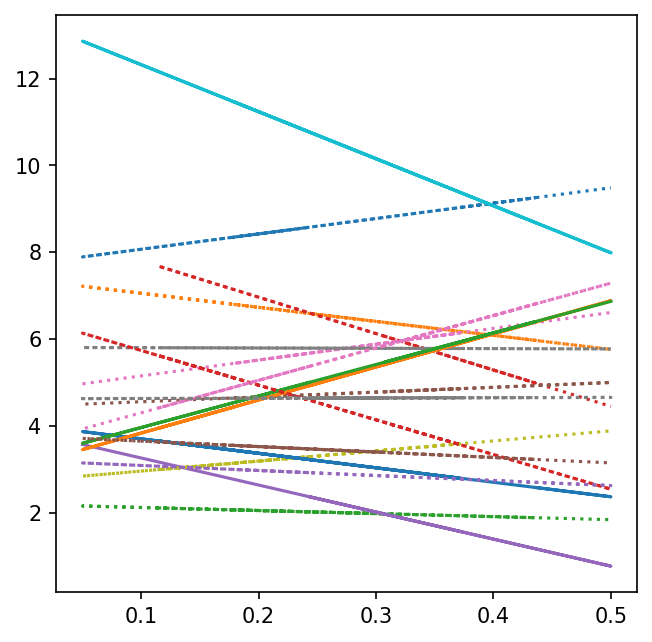

In [3]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)
plt.subplots_adjust(wspace=0.1)
pop_acc = []
for f in files:
    pid, df, acc = load(f, eps_thresh)
    pop_acc.append(acc)
pop_mean_acc = np.mean(pop_acc)
for f in files:
    pid, df, acc = load(f, eps_thresh)
    if np.abs(acc - pop_mean_acc) < 1.25*np.std(pop_acc):
        __, eps, mu_i, __ = get_mean_iai(df)
        x,y,l = get_linear_fit(eps,mu_i)
        plt.plot(x,y, linestyle = l)

In [18]:
eps = np.array(eps); eps = eps.reshape(-1,1)
mu_i = np.array(mu_i); mu_i = mu_i.reshape(-1,1)
mdl = LinearRegression().fit(eps,mu_i)

In [19]:
mdl.score(eps,mu_i)

4.4676351450112506e-05

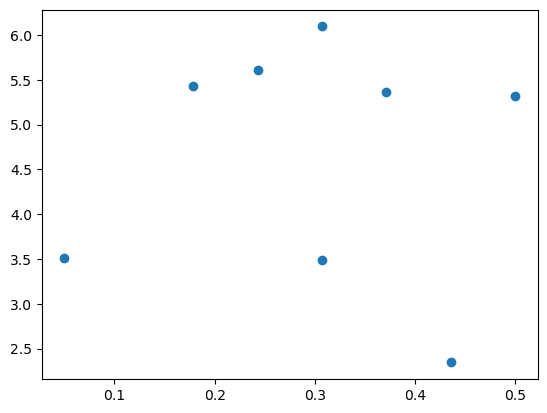

In [20]:
plt.scatter(eps,mu_i)

In [22]:
mdl.coef_

array([[0.06231039]])